The cell below removes the annoying app bar thing at the bottom of a notebook.

In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [26]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import sqlite3
import seaborn as sns
#import pysal as ps
#from pysal.contrib.viz import mapping as maps
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import resample


%matplotlib inline

**These are the imports for AWS**

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, f1_score

The cell below makes it so pandas will show me all the columns.

In [3]:
pd.set_option('display.max_columns', 40)

The below cell loads the spatialite extention to sqlite. I got the code from the spatialite mailing list
https://groups.google.com/d/msg/spatialite-users/o0jUwMUqx_g/OEat2JTUAAAJ
I can get it to work without geopandas. With geopandas imported it kills the ipython kernel within seconds. Ironic! Without one, the other is useless.

In [ ]:
#conn = sqlite3.connect(':memory:') 
#conn.enable_load_extension(True) 
#conn.execute("SELECT load_extension('mod_spatialite')") 

The below code for importing all the sql data came from: https://www.dataquest.io/blog/python-pandas-databases/

In [ ]:
conn = sqlite3.connect("./FPA_FOD_20170508.sqlite")

In [ ]:
#this is if you want to read the data in as tuples

#cur = conn.cursor()
#cur.execute("SELECT * FROM fires;")
#results = cur.fetchall()

In [ ]:
df_all = pd.read_sql_query("SELECT * FROM fires;", conn)
#this grabs the whole db and puts it into a df using the sqlite3.Connection

In [ ]:
df_all.shape

In [ ]:
df_all.head(2)

Since pandas can't handle the geometry information the Shape column is useless anyway, I'm going to drop it. It lives on in the original sqlite db.

In [ ]:
df_all.drop(['Shape'], axis=1, inplace=True)

In [ ]:
df_all.columns

In [ ]:
df_all.STAT_CAUSE_DESCR.unique()

There are entries in my target column that I can't use so I am dropping them.

In [ ]:
df_all.drop(df_all[df_all['STAT_CAUSE_DESCR'] == 'Missing/Undefined'].index, inplace=True)

In [ ]:
df_all.shape

In [ ]:
df_all.dtypes

In [ ]:
df_all.isnull().sum()

I'm going to create a new df, df_pred, by dropping columns from the FPA_FOD data. I'm going to read that into a csv so I have it for later, and then stop using the full set. I will keep the full set on my SSD, of course. I am making these decisions based on the data atlas located here: https://www.kaggle.com/davideanastasia/contour-map-of-us-wildfire-dataset/data

In [ ]:
df_all['FIRE_CODE'].value_counts()

I'm going to drop features that I don't care about and then do feature engineering.

In [ ]:
df_all = df_all.drop(['OBJECTID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
                  'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
                  'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
                  'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
                  'LOCAL_INCIDENT_ID', 'FIRE_NAME',
                  'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
                  'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_TIME', 
                  'STAT_CAUSE_CODE', 'CONT_TIME', 
                  'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 
                  'OWNER_DESCR', 'COUNTY', 'FIPS_NAME'], axis=1)

#at some point redo this. Instead of doing a drop just include all feats I want to keep. Much more readable, shorter

In [ ]:
df_all.shape

In [ ]:
df_all.head(20)

Time for feature engineering.

The 2 columns with the dates for discovery and containment are in the Julian format so I will have to convert them into gregorian timestamps and then engineer a duration. I do think day of year discovered will have some predictive power and will keep that column. I will also engineer month and a day-of-week discovered features.

In [ ]:
df_all['START_DATE'] = pd.to_datetime(df_all['DISCOVERY_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [ ]:
df_all['END_DATE'] = pd.to_datetime(df_all['CONT_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [ ]:
df_all.head(2)

In [ ]:
df_all = df_all.drop(['DISCOVERY_DATE', 'CONT_DATE'], axis=1)

In [ ]:
df_all.head(3)

In [ ]:
df_all['BURN_TIME'] = (df_all['END_DATE'] - df_all['START_DATE']).astype('timedelta64[D]')

In [ ]:
df_all['MONTH'] = pd.DatetimeIndex(df_all['START_DATE']).month

In [ ]:
df_all['DOW'] = pd.DatetimeIndex(df_all['START_DATE']).weekday_name

In [ ]:
df_all.head(3)

In [ ]:
df_all = df_all.drop(['CONT_DOY'], axis=1)

In [ ]:
df_all = df_all.drop(['END_DATE'], axis=1)

In [ ]:
df_all.head(3)

In [ ]:
df_all = df_all.drop(['FOD_ID'], axis=1)

In [ ]:
df_all.head()

In [ ]:
df_all['BURN_TIME'].isnull().sum()

In [ ]:
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(x=df_all['BURN_TIME'].value_counts(), data=df_all)

I'm going to make a new column to use as my target, "Arson". If the cause was arson the value will be 1, else 0.

In [ ]:
# the below works but it isn't vectorized and it takes a hot minute. Going to try to do something faster for practice.

# def make_arson(dataframe):
#     if dataframe['STAT_CAUSE_DESCR'] == 'Arson':
#         val = 1
#     else:
#         val = 0
#     return val
#
#
# df_all['ARSON'] = df_all.apply(make_arson, axis=1)

In [ ]:
#humbug. df_all['ARSON'] = [x for x in df_all['STAT_CAUSE_DESCR'] if x =='Arson' x = 1 else 0]

In [ ]:
df_all.loc[df_all['STAT_CAUSE_DESCR'] != 'Arson', 'ARSON'] = 0
df_all.loc[df_all['STAT_CAUSE_DESCR'] == 'Arson', 'ARSON'] = 1

df_all.head(3)

Wow that was a lot faster.

In [ ]:
df_all['ARSON'] = df_all['ARSON'].astype(int)

Now That I've made the target column for arson I can drop the original column.

In [ ]:
df_all.shape

In [ ]:
df_all.head()

In [ ]:
df_all.drop(['STAT_CAUSE_DESCR'], axis=1, inplace=True)

In [ ]:
df_all.ARSON.value_counts()

In [ ]:
281455/1713742

16.42% of these fires were started by arsonists! Crazy. Also: that's a pretty unbalanced class. Hopefully that won't cause problems. Famous last words.

Over half of all the FIRE_CODE entries are nulls. DROPPED.

In [ ]:
df_all.drop(['FIRE_CODE'], axis=1, inplace=True)

In [ ]:
df_all.isnull().sum()

I'm going to drop FIPS, because I think State will cover location and going all the way down to county risks overfitting on historic data. A county may have an arsonist in it for a time who may have been arrested, moved or died; using a coefficient for that county that was affected while the arsonist was acitive will decrease accuracy. This is also true in a state but given the differences in population between states and differenes in weather conditions I think it will be predictive and have a lower risk of over fitting.

In [ ]:
df_all.drop(['FIPS_CODE'], axis=1, inplace=True)

In [ ]:
df_all.head(3)

In [ ]:
df_all.dtypes

I don't really need to do this because I'm going to label encode and then one-hot encode it later but that will make just doing one loop for all the things that need encoding simpler, if a little more time consuming to run. Worth it.

In [ ]:
df_all['MONTH'] = df_all['MONTH'].apply(lambda x: calendar.month_name[x])

Whoops, ran it twice.

In [ ]:
df_all.head(2)

After much consideration I am going to drop the start date, keep the day-of-year, but transform it to be cyclic so the algorithms can see that 1 and 365 are actually closer than 60 and 365.

In [ ]:
df_all.drop(['START_DATE'], axis=1, inplace=True)

I need to encode my categorical values. I can use one-hot encoding or get dummies and drop one column. For month and day-of-week there are only 12 and 7 categories, respectively, so for them I'll get dummies. For the other 2 I'll use one-hot because there are so categories and I don't want to dataframe that big considering how much modeling I'm doing, the ram required would get too big.

Now I'm going to try impute data for BURN_TIME. I want to test to see if the data is missing at random. I'm going to check for a correlation between BURN_TIME and the other features.

In [ ]:
df_all.head(2)

In this notebook I'm going to just drop the missing burn time values and then include it in my analysis. See what that gets me.

In [ ]:
df_wburn = df_all.drop(df_all[df_all['BURN_TIME'].isnull() == True].index)

In [ ]:
df_wburn.shape

In [ ]:
df_wburn.STATE.nunique()

In [ ]:
df_wburn.head(20)

In [ ]:
df_wburn.isnull().sum()

In [ ]:
df_wburn.dtypes

I want to make the DISCOVERED_DOY cyclic.

In [ ]:
df_wburn.shape

In [ ]:
df_wburn['DOY_SIN'] = np.sin(df_wburn.DISCOVERY_DOY*(2.*np.pi/365))
df_wburn['DOY_COS'] = np.cos(df_wburn.DISCOVERY_DOY*(2.*np.pi/365))

In [ ]:
df_wburn.shape

In [ ]:
df_wburn.head(2)

In [ ]:
df_wburn = df_wburn.drop(['DISCOVERY_DOY'], axis=1)

In [ ]:
df_wburn.shape

In [ ]:
df_wburn.head(2)

I need to scale this. There are a ton of outliers so I'm going to use RobustScaler.

In [ ]:
#robsca = RobustScaler()

In [ ]:
#df_wburn['BURN_TIME'] = robsca.fit_transform(df_wburn['BURN_TIME'].values.reshape(-1, 1))

In [ ]:
#df_wburn.head(10)

Turns out that with all the zeros in BURN_TIME it's a sparse matrix so robust scalar won't work. Sparse data often calls for MaxAbsScaler but that scales by the highest absolute value, and since there are outliers in both BURN_TIME and FIRE_SIZE I don't want to do that.

In [ ]:
ss = StandardScaler()

In [ ]:
df_wburn['BURN_TIME'] = ss.fit_transform(df_wburn['BURN_TIME'].values.reshape(-1, 1))

In [ ]:
df_wburn.shape

In [ ]:
df_wburn.head(3)

In [ ]:
plt.hist(df_wburn.FIRE_SIZE)

In [ ]:
df_wburn.shape

In [ ]:
robsca = RobustScaler()

In [ ]:
df_wburn['FIRE_SIZE'] = robsca.fit_transform(df_wburn['FIRE_SIZE'].values.reshape(-1, 1))

In [ ]:
df_wburn.head(30)

In [ ]:
df_wburn.shape

In [ ]:
df_wburn.to_csv('./data_to_encode.csv', index=False)

In [ ]:
df_wburn = pd.read_csv('./data_to_encode.csv')
print(df_wburn.shape)

OKAY. Now everything that needed to be is scaled and normalized. Time to encode my categorical values.

THE BELOW WAS THE ORIGINAL PLAN BUT I SWITCHED TO ONE-HOT ENCODING EVERYTHING AND USING PCA TO REDUCE DIMENSIONALITY.

I need to drop 1 dummy variable for each of the features I just got dummies from. I'm choosing Wednesday because it's the middle of the weekdays, of which there are 5 vs just 2 weekends (I believe that the ratio of causes that fires started on weekend days had will be different from weekdays. I am hoping this will help with interpretation.) I'm choosing January essentially at random, it's the first value which is what get_dummies has as a parameter.

In [ ]:
# categorical_vars=['MONTH','DOW']
# for var in categorical_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df_all[var], prefix=var, drop_first=False)
#     df_all1=df_all.join(cat_list)
#     df_all=df_all1

#DECIDED TO DO ONE-HOT ENCODING ON EVERYTHING AND THEN USE PCA TO DEAL WITH THE COLLINIERITY PROBLEM.

In [ ]:
lab_enc = LabelEncoder()
oh_enc = OneHotEncoder()

need_encoding = [df_wburn['STATE'], df_wburn['MONTH'], df_wburn['DOW']]

for feat in need_encoding:
    feat_int_encoded = lab_enc.fit_transform(feat)
    feat_int_encoded_reshape = feat_int_encoded.reshape(len(feat_int_encoded), 1) 
    feat_onehot_encoded = oh_enc.fit_transform(feat_int_encoded_reshape)
    df_feat = pd.DataFrame(feat_onehot_encoded.toarray())
    df_wburn2 = pd.merge(df_wburn, df_feat, left_index=True, right_index=True)
    df_wburn = df_wburn2

df_wburn.shape

In [ ]:
df_wburn.head()

In [ ]:
df_wburn.columns

In [ ]:
df_wburn.head(3)

In [ ]:
df_wburn.tail(3)

In [ ]:
df_wburn.STATE.nunique()

In [ ]:
df_wburn.DOW.nunique()

In [ ]:
df_wburn.MONTH.nunique()

In [ ]:
df_wburn.drop(['STATE', 'MONTH', 'DOW'], axis=1, inplace=True)

In [ ]:
df_wburn.shape

In [ ]:
df_wburn.isnull().sum().sum()

I wrote the dataframe to .csv as this is what I'm going to perform PCA on and I wanted it as a file.

In [ ]:
df_wburn.to_csv('./final_df.csv', index=False)

In [4]:
df_wburn = pd.read_csv('./final_df.csv')

Futher down you can see there's a strange phenomenon where the first PCA feature after transformation accounts for over 99.99% of the variation. In the next cells I tried to discover why that might be.

In [ ]:
print(np.corrcoef(df_wburn['FIRE_SIZE'], df_wburn['BURN_TIME']))

That's a nice looking dataframe for machine learning. To deal with the all that dimensionality and collinearity I'm going to use PCA.

In [ ]:
for i in df_wburn.columns:
    print(np.corrcoef(df_wburn['ARSON'], df_wburn[i])[0,1])

I was thinking that one un-transformed feature might account for nearly all the variation so I checked corrcoeffs above. It's actually nicely distributed. The largest one is 0.3, which is not strong.

Below I looked to see if having both DOY_SIN and DOY_COS in the data was causing the weirdness. It was not.

In [ ]:
df_nosin = df_wburn.drop(['DOY_SIN'], axis=1)

In [ ]:
df_nosin.head(3)

In [ ]:
pca_nosin = PCA()
pca_nosin.fit(df_nosin.drop(['ARSON'], axis=1))

In [ ]:
var_exp_nosin = pca_nosin.explained_variance_ratio_
cum_var_exp_nosin = np.cumsum(var_exp_nosin)

In [ ]:
len(pca_nosin.components_)

In [ ]:
plt.figure(figsize=(15,10))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 75))
plt.plot(component_number, cum_var_exp_nosin, lw=3)

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,74])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [ ]:
print(cum_var_exp_nosin)

Taking out DOY_SIN actually increased the percentage of variation accounted for by the first PCA feature. So I went back to using the full dataframe. At this point, all the categorical data has been one-hot encoded, the PCA transformation has taken care of the collinearity that encoding causes, the numerical data has all been scaled, no correlation coefficients were very strong, and taking out one of the DOY columns basically did nothing. I conclude that something **extremely** improbable has occured, and because I have a good grasp on statistics I know that happens. I am moving on to do a PCA transformation on the entire data set.

In [ ]:
pca_wburn = PCA()
pca_wburn.fit(df_wburn.drop(['ARSON'], axis=1))

The next few cells are from the PCA lesson.

In [ ]:
var_exp_wburn = pca_wburn.explained_variance_ratio_
cum_var_exp_wburn = np.cumsum(var_exp_wburn)

In [ ]:
len(pca_wburn.components_)

In [ ]:
plt.figure(figsize=(15,10))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 76))
plt.plot(component_number, cum_var_exp_wburn, lw=3)

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,74])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

I don't trust that result at all. But I have tried a bunch of different ways to catch something going wrong with it. I dropped one of my cyclical DOY columns - nothing. I scaled and normalized both my numeric columns: fire size and burn time - nothing. I checked the corrcoeffs of each feature against Arson: the biggest one is 0.3 - nothing there either. I checked to see what the correlation between BURN_TIME and FIRE_SIZE is, it's 0.1 - nothing. I have looked over the code, which is quite simple and would be hard to screw up in such a way that it would still run, several times and found no errors. I suppose it's possible that something extraordinarily improbable has occurred here.

In [ ]:
print(cum_var_exp_wburn)

I'll keep 4 of my pca components for now. That keeps 99.999984% of my variance explained while dropping almost all of my variables. This solves the high dimensionality my data had after one-hot encoding. It also is going to make everything run much faster than if I had needed to keep a large number of features. After I've gotten to the point where I'm scoring models I'll try a few other numbers of PCA features to use, all low to keep my dimensionality down.

**UPDATE:** Setled on 6 PCA features after looking at scores for several different numbers of kept features on a logistic regression.

Time to make my training and testing sets. Then I'll transform with PCA and use that.

In [5]:
X = df_wburn.drop(['ARSON'], axis=1)
y = df_wburn['ARSON']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
pca_6 = PCA(n_components=6)
pca_6.fit(X_train)
Xt_train = pca_6.transform(X_train)
Xt_test = pca_6.transform(X_test)

About half of the code for these models came from : http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

**Logistic regression.**

In [8]:
lr = LogisticRegression()
lr.fit(Xt_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
lr.score(Xt_test, y_test)

0.839936340794759

**Number of estimators for Random Trees, Random Forest, and Gradient Boosting Classifier.** 10 is a common choice so I went with that. This will be tuned later.

In [10]:
n_estimator = 50

**Random Trees Embedding piped to Logistic Regression.** This was not part of my original plan but I found it online and it looked cool.

In [11]:
rt = RandomTreesEmbedding(max_depth=4, n_estimators=n_estimator,
    random_state=42)

rt_lr = LogisticRegression()
rt_lr_pipeline = make_pipeline(rt, rt_lr)
rt_lr_pipeline.fit(Xt_train, y_train)

Pipeline(memory=None,
     steps=[('randomtreesembedding', RandomTreesEmbedding(max_depth=4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=42, sp...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [12]:
rt_lr_pipeline.score(Xt_test, y_test)

0.839936340794759

**Random Forest.**

In [13]:
rf = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf.fit(Xt_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
rf.score(Xt_test, y_test)

0.839936340794759

**Gradient Boosting Classifier**

In [15]:
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(Xt_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [16]:
grd.score(Xt_test, y_test)

0.839936340794759

**XGBoost.**

In [17]:
xgb = XGBClassifier()
xgb.fit(Xt_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
xgb.score(Xt_test, y_test)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8402579069856168

**Gaussian Naive Bayes.** For all binary features a Bernoulli kernel is used, for categorical data, a multinomial. My data is neither so I went with a Gaussian kernel.

In [19]:
gnb = GaussianNB()
gnb.fit(Xt_train, y_train)

GaussianNB(priors=None)

In [20]:
gnb.score(Xt_test, y_test)

0.6170746197071022

**Calibrated Classifier with LinearSVC.** LinearSVC doesn't have a predict_probas method. Calibrated Classifer not only improves it's performance, it has a predict_probas method, so I use it here. It requires an extra split. This model's computational demands increase dramatically with dimensionality so I went down to using only 2 PCA features for it.

In [21]:
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X, y, test_size=0.8, random_state=42)

In [22]:
pca2 = PCA(n_components=2)
pca2.fit(X_train_svc)
Xt_train_svc = pca2.transform(X_train_svc)
Xt_test_svc = pca2.transform(X_test_svc)

In [23]:
lsvc = LinearSVC(random_state=0)

In [24]:
cal_class_lsvc = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')
cal_class_lsvc.fit(Xt_train_svc, y_train_svc)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: R

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
            cv=2, method='sigmoid')

In [25]:
cal_class_lsvc.score(Xt_test_svc, y_test_svc)

0.8409444248385695

The below cell was run and an ROC curve was generated below. It was terrible so I commented this all out so it wouldn't be re-run if I end up restarting this kernel and going through everything again.

Wow definitely don't use that one. I'm going to comment grd_lm out above.

The code in the next 2 cells also comes from a GA lesson.

In [26]:
def roc2(probas, true, step=0.01, plot=True):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    plot is a boolean for whether we want to generate a plot
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
        
    if plot: # Only generate a plot if plot == True
        
        plt.rcParams['font.size'] = 14
        plt.plot(FPRs, TPRs, color="orange")
        plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('Receiver Operating Characteristic')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show();
        
    return np.array(TPRs), np.array(FPRs) # We'll neet to have our TPRs and FPRs as arrays so we can use broadcasting in the next function.

def sen_spec(probas, true, stat="sensitivity", stat_val=0.5, step=0.01):
    '''
    This is the function that the assignment is asking for. We'll feed in our probas and true vectors as we do with the previous function, as well
    as we are looking at, as well as the value of that stat that we want to find, and the step size for our roc function.
    
    '''
    
    stat = stat.lower() # turn the string into lowercase for ease of comparison
    
    assert(stat in ["sensitivity", "specificity"]) # Throw an error if the user did not write sensitivity or specificity
    
    TPRs, FPRs = roc2(probas, true, step=step, plot=False) # use our roc function to get vectors of TPR and FPR
    
    if stat == "sensitivity":
        diffs = np.absolute(TPRs - stat_val) # We won't necessarily be able to find a threshold that gives the exact value we're looking for, but we can find the one that gets us the closest.
        loc = np.argmin(diffs) # We want to find the index of the TPR that was closest to the value we specified
        threshold = loc * step
        sensitivity = TPRs[loc]
        spec_corr = (1 - FPRs[loc])
        
        print("Sensitivity: {:.5f}%, Specificity: {:.5f}%, Threshold: {}%".format(sensitivity*100, spec_corr*100, threshold*100))
        return TPRs, FPRs
    
    elif stat == "specificity":
        specificities = 1 - FPRs # FPR = 1 - specificity --> specificity = 1 - FPR
        diffs = np.absolute(specificities - stat_val)
        loc = np.argmin(diffs)
        threshold = loc * step
        specificity = specificities[loc]
        sens_corr = (TPRs[loc])
        
        print("Specificity: {:.5f}%, Sensitivity: {:.5f}%, Threshold: {}%".format(specificity*100, sens_corr*100, threshold*100))
        return TPRs, FPRs

In [27]:
def auc(y, x):
    
    auc = 0
    for i in range(1,len(x)):
        auc += ((y[i] + y[i-1])/2)*abs((x[i] - x[i-1]))
        
    return auc

Going to re-run all the models for scoring with the above functions.

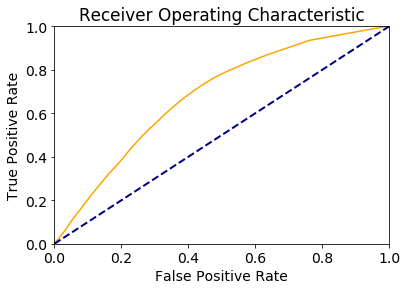

(array([1.        , 0.9999319 , 0.99982975, 0.99965949, 0.99918278,
        0.99897848, 0.99850177, 0.99775266, 0.9360869 , 0.86972215,
        0.83097249, 0.79395941, 0.7652547 , 0.73668619, 0.70508717,
        0.67253473, 0.64257014, 0.62179924, 0.59319668, 0.55900981,
        0.52131572, 0.47664124, 0.43714247, 0.39961863, 0.37544266,
        0.34929175, 0.32232362, 0.28977118, 0.25538001, 0.21720921,
        0.16960637, 0.11546581, 0.05696677, 0.02557205, 0.00769545,
        0.0023495 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [28]:
roc2(lr.predict_proba(Xt_test), y_test)

In [ ]:
#TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
#this was with 5 pca feats


In [ ]:
#TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
# 7 PCA feats

In [ ]:
#TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
# 8 pca feats

A "by-hand gridsearch" shows that 6 PCA features gives the best sensitivity. Could be a local maxima but I'm not willing to make the data array even bigger than 8 given how many rows I have.

In [29]:
TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
#with 6 pca feats

Specificity: 98.63149%, Sensitivity: 2.55721%, Threshold: 33.0%


In [30]:
auc(TPRs_lr, FPRs_lr)

0.6796437396453459

In [31]:
lr_preds = lr.predict(Xt_test)

In [32]:
print(classification_report(y_test, lr_preds))


             precision    recall  f1-score   support

          0       0.84      1.00      0.91    154109
          1       0.00      0.00      0.00     29368

avg / total       0.71      0.84      0.77    183477



/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Bad bad bad. Gotta balance. No way around it.

This "pipeline" was a random trees embedding with a logistic regression performed on that output.

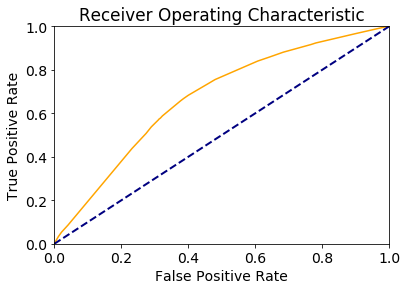

(array([1.        , 0.99996595, 0.9999319 , 0.99965949, 0.99897848,
        0.99683329, 0.967073  , 0.9235903 , 0.91664397, 0.88119722,
        0.85926859, 0.84037047, 0.80560474, 0.75514165, 0.739921  ,
        0.68322664, 0.66807409, 0.65731408, 0.59949605, 0.58808908,
        0.57760147, 0.57440071, 0.56966767, 0.53776219, 0.5078657 ,
        0.43795968, 0.43795968, 0.0867611 , 0.05339145, 0.04035004,
        0.04035004, 0.03462953, 0.01508445, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [33]:
roc2(rt_lr_pipeline.predict_proba(Xt_test), y_test)

In [34]:
TPRs_rt, FPRs_rt = sen_spec(probas=rt_lr_pipeline.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.73207%, Sensitivity: 3.46295%, Threshold: 31.0%


In [35]:
auc(TPRs_rt, FPRs_rt)

0.6714112630429396

Now for the random forest.

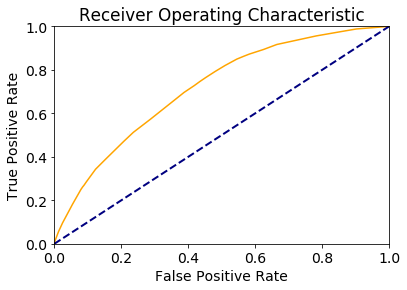

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 9.88014165e-01, 9.75074911e-01, 9.56006538e-01,
        9.16609916e-01, 8.93489512e-01, 8.72548352e-01, 8.62912013e-01,
        8.49461999e-01, 8.19940071e-01, 7.92495233e-01, 7.63926723e-01,
        7.46560883e-01, 7.27424408e-01, 6.96131844e-01, 6.61944974e-01,
        6.31129120e-01, 5.73345138e-01, 5.12530646e-01, 4.71567693e-01,
        3.88211659e-01, 3.42958322e-01, 2.84970035e-01, 2.69408880e-01,
        2.61543176e-01, 2.49659493e-01, 1.82307273e-01, 9.61590847e-02,
        5.61836012e-02, 1.68550804e-02, 4.90329610e-03, 2.38354672e-04,
        1.36202670e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [36]:
roc2(rf.predict_proba(Xt_test), y_test)

In [37]:
TPRs_rf, FPRs_rf = sen_spec(probas=rf.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.74115%, Sensitivity: 5.61836%, Threshold: 32.0%


In [38]:
auc(TPRs_rf, FPRs_rf)

0.7155682523253207

Next is Gradient Boosted Trees Classifier

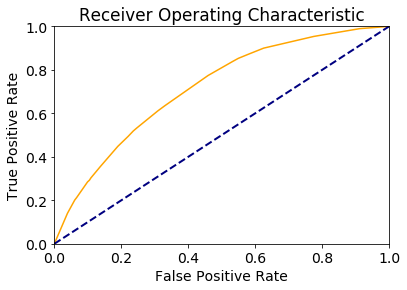

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.98944429,
        0.95362299, 0.89985699, 0.87183329, 0.85290112, 0.83890629,
        0.77407382, 0.63524925, 0.61117543, 0.532927  , 0.51903432,
        0.49390493, 0.44797058, 0.35565922, 0.30328929, 0.29229093,
        0.28469763, 0.24594797, 0.21271452, 0.20113729, 0.14120812,
        0.13964179, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [39]:
roc2(grd.predict_proba(Xt_test), y_test)

In [40]:
TPRs_grd, FPRs_grd = sen_spec(probas=grd.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 100.00000%, Sensitivity: 0.00000%, Threshold: 31.0%


In [41]:
auc(TPRs_grd, FPRs_grd)

0.7159622564115757

Now for XGBoost

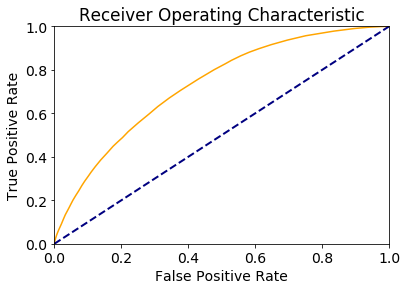

(array([1.00000000e+00, 1.00000000e+00, 9.98944429e-01, 9.96050123e-01,
        9.90159357e-01, 9.78071370e-01, 9.56857804e-01, 9.36972215e-01,
        9.15826750e-01, 8.97303187e-01, 8.81401525e-01, 8.64682648e-01,
        8.43673386e-01, 8.27873876e-01, 8.01144102e-01, 7.57627349e-01,
        7.05495778e-01, 6.70695996e-01, 6.31265323e-01, 5.96056933e-01,
        5.56558159e-01, 5.15799510e-01, 4.88661128e-01, 4.67924271e-01,
        4.48413239e-01, 4.17563334e-01, 3.85249251e-01, 3.54807954e-01,
        3.29576410e-01, 3.10746391e-01, 2.87762190e-01, 2.67638246e-01,
        2.43598475e-01, 2.22487061e-01, 2.00728684e-01, 1.83396895e-01,
        1.67290929e-01, 1.52887497e-01, 1.33580768e-01, 1.15840370e-01,
        9.11876873e-02, 6.46622174e-02, 5.28466358e-02, 4.12694089e-02,
        3.21097794e-02, 2.35630618e-02, 1.81490057e-02, 1.42331790e-02,
        9.36393353e-03, 7.11658949e-03, 5.78861346e-03, 4.90329610e-03,
        4.52873876e-03, 2.72405339e-03, 1.46417870e-03, 1.021520

In [42]:
roc2(xgb.predict_proba(Xt_test), y_test)

In [43]:
TPRs_xgb, FPRs_xgb = sen_spec(probas=xgb.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.99617%, Sensitivity: 5.28466%, Threshold: 42.0%


In [44]:
auc(TPRs_xgb, FPRs_xgb)

0.7289559548747685

Now Gaussian Naive Bayes Classifier.

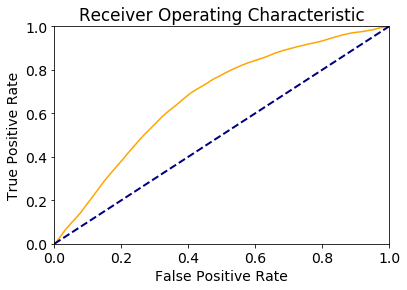

(array([0.99972759, 0.99673114, 0.99656088, 0.99632253, 0.99611822,
        0.99608417, 0.99591392, 0.99577772, 0.99567557, 0.99550531,
        0.99533506, 0.99523291, 0.99519886, 0.99506265, 0.99485835,
        0.99417734, 0.99267911, 0.98913784, 0.98593707, 0.98433669,
        0.98348543, 0.98307682, 0.98099973, 0.97807137, 0.97582403,
        0.97034187, 0.95971806, 0.94957096, 0.93959412, 0.92944702,
        0.9183465 , 0.90353446, 0.8902547 , 0.87700899, 0.8649891 ,
        0.85644239, 0.84554617, 0.83345819, 0.81997412, 0.80580904,
        0.79293789, 0.78173522, 0.77032825, 0.76093026, 0.75173658,
        0.74162354, 0.73137428, 0.72064832, 0.70859439, 0.69442931,
        0.67754018, 0.66099156, 0.64662217, 0.63126532, 0.61767911,
        0.60518251, 0.5869654 , 0.55938436, 0.53061155, 0.4997957 ,
        0.46901389, 0.44194361, 0.41637156, 0.3926042 , 0.37632798,
        0.35007491, 0.3213021 , 0.28912422, 0.25071506, 0.21400844,
        0.17971942, 0.14526015, 0.12043721, 0.09

In [45]:
roc2(gnb.predict_proba(Xt_test), y_test)

In [46]:
TPRs_gnb, FPRs_gnb = sen_spec(probas=gnb.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.60359%, Sensitivity: 2.47889%, Threshold: 75.0%


In [47]:
auc(TPRs_gnb, FPRs_gnb)

0.6733207200219891

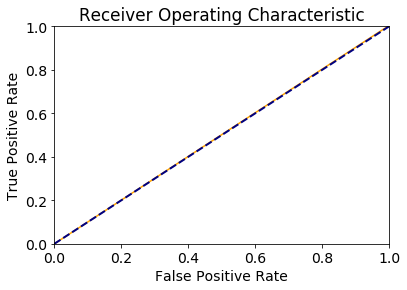

(array([1.00000000e+00, 9.99965733e-01, 9.99948600e-01, 9.99940034e-01,
        9.99914334e-01, 9.99888634e-01, 9.99862934e-01, 9.99837234e-01,
        9.99828667e-01, 9.99802967e-01, 9.99768701e-01, 9.99734434e-01,
        9.99631635e-01, 9.99520269e-01, 9.99297536e-01, 9.98637906e-01,
        9.87724017e-01, 2.56998938e-05, 8.56663126e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [51]:
roc2(cal_class_lsvc.predict_proba(Xt_test_svc), y_test_svc)

I screwed up by calibrating and training on the same data set, which is fatal to this technique. I'll have to go fix that.

In [52]:
TPRs_calclass_lsvc, FPRs_calclass_lsvc = sen_spec(probas=cal_class_lsvc.predict_proba(Xt_test_svc), true=y_test_svc, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 99.99644%, Sensitivity: 0.00257%, Threshold: 17.0%


In [53]:
auc(TPRs_calclass_lsvc, FPRs_calclass_lsvc)

0.5020649469298946

It would appear that having my classes unbalanced, cases of Arson make up only 16% of the instances in my sample. Has truly come back to haunt me. I will now deal with that in various ways.

In [54]:
df_wburn.ARSON.value_counts()

0    771131
1    146252
Name: ARSON, dtype: int64

In [56]:
# Method 1: downsample majority class

df_minority = df_wburn[df_wburn['ARSON']==1]
df_majority = df_wburn[df_wburn['ARSON']==0]
 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=146252,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.ARSON.value_counts()

1    146252
0    146252
Name: ARSON, dtype: int64

In [126]:
df_downsampled.to_csv('./df_down.csv', index=False)

In [129]:
df_downsampled.shape

(292504, 76)

In [130]:
Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

In [58]:
Xd_train, Xd_test, y_train_down, y_test_down = train_test_split(Xd, yd, test_size=0.2, random_state=42)

In [59]:
pca_6_down = PCA(n_components=6)
pca_6_down.fit(Xd_train)
Xt_train_down = pca_6_down.transform(Xd_train)
Xt_test_down = pca_6_down.transform(Xd_test)

Initially I tested on down-sampled data. This is wrong. I need to train on my downsampled data and then test against the full data set. Rather and doubling the number of cells below this I went back and re-did it the proper way.

In [60]:
lr_down = LogisticRegression()
lr_down.fit(Xt_train_down, y_train_down)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
lr_down.score(Xt_test_down, y_test_down)

0.6410317772345772

In [62]:
rt_down = RandomTreesEmbedding(max_depth=4, n_estimators=n_estimator,
    random_state=42)

rt_lr_down = LogisticRegression()
rt_lr_pipeline_down = make_pipeline(rt_down, rt_lm_down)
rt_lr_pipeline_down.fit(Xt_train_down, y_train_down)

Pipeline(memory=None,
     steps=[('randomtreesembedding', RandomTreesEmbedding(max_depth=4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=42, sp...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [63]:
rf_down = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf_down.fit(Xt_train_down, y_train_down)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
grd_down = GradientBoostingClassifier(n_estimators=n_estimator)
grd_down.fit(Xt_train_down, y_train_down)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [65]:
xgb_down = XGBClassifier()
xgb_down.fit(Xt_train_down, y_train_down)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [99]:
gnb_down = GaussianNB()
gnb_down.fit(Xt_train_down, y_train_down)

GaussianNB(priors=None)

In [67]:
cal_class_lsvc_down = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')
cal_class_lsvc_down.fit(Xt_train_down, y_train_down)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:447: R

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
            cv=2, method='sigmoid')

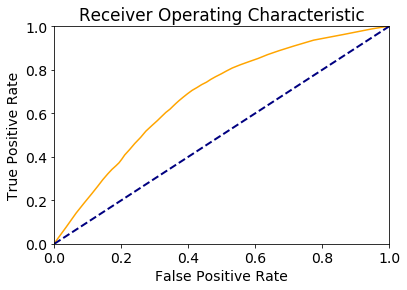

(array([1.        , 1.        , 1.        , 0.99982951, 0.99979541,
        0.99979541, 0.99979541, 0.99979541, 0.99979541, 0.99979541,
        0.99972721, 0.99969312, 0.99955672, 0.99948853, 0.99942033,
        0.99942033, 0.99935213, 0.99935213, 0.99924984, 0.99911344,
        0.99907935, 0.99904525, 0.99890886, 0.99880656, 0.99877246,
        0.99863607, 0.99843148, 0.99819279, 0.99764722, 0.98786102,
        0.96218502, 0.93657722, 0.90970778, 0.88819177, 0.87005149,
        0.85252498, 0.8382719 , 0.82289358, 0.80840181, 0.79445562,
        0.78194156, 0.76837044, 0.75606097, 0.74341051, 0.73212398,
        0.71831418, 0.70580012, 0.6902854 , 0.67429331, 0.65772155,
        0.64445733, 0.63269342, 0.6192587 , 0.60432366, 0.58519453,
        0.56657687, 0.54352644, 0.51802094, 0.48927609, 0.46121322,
        0.43420739, 0.40863368, 0.38875439, 0.37262591, 0.3589184 ,
        0.34176697, 0.3214103 , 0.29460906, 0.26392062, 0.23094759,
        0.18910901, 0.14147373, 0.07648242, 0.02

In [68]:
roc2(lr_down.predict_proba(Xt_test_down), y_test_down)

In [69]:
TPRs_lr_down, FPRs_lr_down = sen_spec(probas=lr_down.predict_proba(Xt_test_down), true=y_test_down, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.71118%, Sensitivity: 2.94268%, Threshold: 73.0%


In [70]:
auc(TPRs_lr_down, FPRs_lr_down)

0.6815962112783676

Not exactly the sensitivity score I was looking for. AUC-ROC score is at 68.15%, not much of a change.

In [71]:
lr_down_preds = lr_down.predict(Xt_test_down)

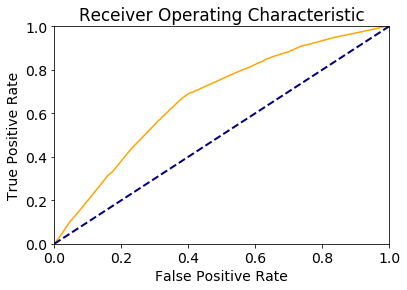

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        9.99931803e-01, 9.99897705e-01, 9.99829509e-01, 9.99829509e-01,
        9.99829509e-01, 9.99522624e-01, 9.99249838e-01, 9.99249838e-01,
        9.98636069e-01, 9.98363283e-01, 9.98158693e-01, 9.97817711e-01,
        9.97238040e-01, 9.97033450e-01, 9.96965254e-01, 9.96862959e-01,
        9.95021652e-01, 9.77631534e-01, 9.62832884e-01, 9.62798786e-01,
        9.60411907e-01, 9.48818495e-01, 9.21062502e-01, 9.16084155e-01,
        9.10355645e-01, 9.03842875e-01, 8.83179323e-01, 8.76598356e-01,
        8.73256726e-01, 8.60299383e-01, 8.45364340e-01, 8.38476489e-01,
        8.31247656e-01, 8.09527057e-01, 7.92307430e-01, 7.22167286e-01,
        7.11017151e-01, 6.94513588e-01, 6.89364749e-01, 6.86398200e-01,
        6.80294609e-01, 6.76611996e-01, 6.71122174e-01, 6.68053330e-01,
        6.63927439e-01, 6.46366829e-01, 6.27749173e-01, 6.244416

In [72]:
roc2(rt_lr_pipeline_down.predict_proba(Xt_test_down), y_test_down)

In [73]:
TPRs_pipeline_down, FPRs_pipeline_down = sen_spec(probas=rt_lr_pipeline_down.predict_proba(Xt_test_down), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.50217%, Specificity: 2.47138%, Threshold: 24.0%


In [74]:
auc(TPRs_pipeline_down, FPRs_pipeline_down)

0.6707642199825037

That actually got worse.

In [75]:
rt_lr_pipeline_down_preds = rt_lr_pipeline_down.predict(Xt_test_down)

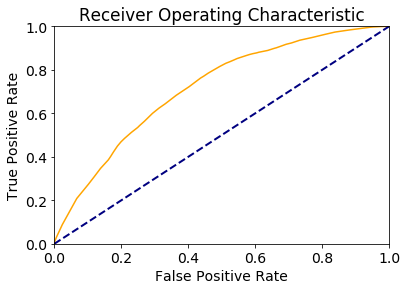

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.99911344, 0.99716984,
        0.99590821, 0.99546493, 0.99488526, 0.98390562, 0.97374433,
        0.96331026, 0.94915948, 0.93623623, 0.93180346, 0.92361987,
        0.91748218, 0.90905991, 0.9013878 , 0.89838715, 0.88918062,
        0.88086064, 0.87806458, 0.87445017, 0.87052886, 0.86722133,
        0.85862857, 0.8520817 , 0.84553483, 0.83663518, 0.83066799,
        0.82736045, 0.81508508, 0.78460122, 0.77096191, 0.76250554,
        0.7356361 , 0.72305384, 0.68329526, 0.64404815, 0.62450984,
        0.59989089, 0.56333754, 0.54424251, 0.53462679, 0.51256521,
        0.48477512, 0.46864664, 0.44958571, 0.42302315, 0.40082518,
        0.38606063, 0.34657483, 0.30889624, 0.27438879, 0.20847683,
        0.08824633, 0.02987009, 0.01302554, 0.00

In [76]:
roc2(rf_down.predict_proba(Xt_test_down), y_test_down)

In [77]:
TPRs_rf_down, FPRs_rf_down = sen_spec(probas=rf_down.predict_proba(Xt_test_down), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.48853%, Specificity: 6.16302%, Threshold: 22.0%


In [78]:
auc(TPRs_rf_down, FPRs_rf_down)

0.7162265120690428

In [79]:
rf_down_preds = rf_down.predict(Xt_test_down)

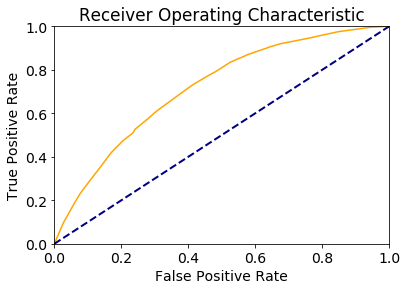

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99618099,
        0.99590821, 0.99495346, 0.97551744, 0.97507416, 0.96109387,
        0.94922767, 0.94711358, 0.91969857, 0.90418386, 0.89644355,
        0.8934429 , 0.86889215, 0.86435708, 0.85985611, 0.85753742,
        0.8520135 , 0.83486207, 0.82381423, 0.79312579, 0.77355338,
        0.73000989, 0.61717871, 0.60176629, 0.57864766, 0.52681829,
        0.51249702, 0.50376786, 0.47376138, 0.41988611, 0.36601084,
        0.3510758 , 0.28451598, 0.2563167 , 0.23214103, 0.19098442,
        0.09653221, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [80]:
roc2(grd_down.predict_proba(Xt_test_down), y_test_down)

In [81]:
TPRs_grd_down, FPRs_grd_down = sen_spec(probas=grd_down.predict_proba(Xt_test_down), true=y_test_down, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 100.00000%, Sensitivity: 0.00000%, Threshold: 66.0%


In [82]:
auc(TPRs_grd_down, FPRs_grd_down)

0.7159846158427446

In [83]:
grd_down_preds = grd_down.predict(Xt_test_down)

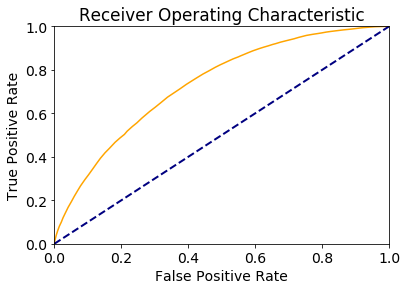

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99931803e-01,
        9.99352133e-01, 9.98738364e-01, 9.98567873e-01, 9.98226890e-01,
        9.97238040e-01, 9.96317387e-01, 9.95055751e-01, 9.94305589e-01,
        9.93316739e-01, 9.90793467e-01, 9.87485934e-01, 9.83666928e-01,
        9.76710881e-01, 9.73573840e-01, 9.69482047e-01, 9.67061070e-01,
        9.63548948e-01, 9.58331913e-01, 9.49193576e-01, 9.42953592e-01,
        9.38554915e-01, 9.32996897e-01, 9.27063798e-01, 9.20789716e-01,
        9.16732022e-01, 9.10696628e-01, 9.04490742e-01, 8.97875678e-01,
        8.88089474e-01, 8.79121629e-01, 8.71483616e-01, 8.65209534e-01,
        8.59310533e-01, 8.50513179e-01, 8.41408941e-01, 8.32031916e-01,
        8.23507348e-01, 8.11982133e-01, 7.96501517e-01, 7.80679920e-01,
        7.61653084e-01, 7.33692502e-01, 7.12585672e-01, 6.93831623e-01,
        6.74463805e-01, 6.48480922e-01, 6.27374092e-01, 6.090633

In [84]:
roc2(xgb_down.predict_proba(Xt_test_down), y_test_down)

In [85]:
TPRs_xgb_down, FPRs_xgb_down = sen_spec(probas=xgb_down.predict_proba(Xt_test_down), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.07935%, Specificity: 9.51532%, Threshold: 17.0%


In [86]:
auc(TPRs_xgb_down, FPRs_xgb_down)

0.7333127631797414

In [87]:
xgb_down_preds = xgb_down.predict(Xt_test_down)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


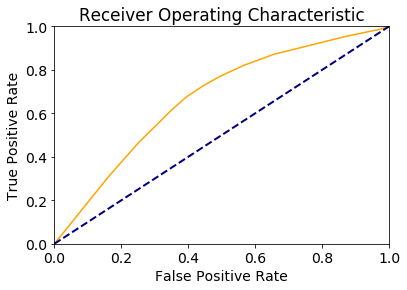

(array([1.        , 0.9999318 , 0.99982951, 0.99982951, 0.99976131,
        0.99976131, 0.99976131, 0.99969312, 0.99965902, 0.99962492,
        0.99962492, 0.99955672, 0.99952262, 0.99948853, 0.99948853,
        0.99942033, 0.99938623, 0.99928394, 0.99911344, 0.99894295,
        0.99887476, 0.99860197, 0.99849968, 0.99836328, 0.9981246 ,
        0.9980223 , 0.99788591, 0.99778361, 0.99764722, 0.99744263,
        0.99723804, 0.99703345, 0.99662427, 0.99641968, 0.99624919,
        0.9960105 , 0.99590821, 0.99543083, 0.99508985, 0.99451018,
        0.9941351 , 0.99358953, 0.99270297, 0.99154363, 0.99028199,
        0.98878167, 0.9861902 , 0.95331947, 0.87134722, 0.81944965,
        0.76867733, 0.72642957, 0.67477069, 0.61557609, 0.55849558,
        0.46438436, 0.37027313, 0.31268115, 0.2110001 , 0.05118151,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [112]:
roc2(cal_class_lsvc_down.predict_proba(Xt_test_down), y_test_down)

In [113]:
TPRs_cal_class_lsvc_down, FPRs_cal_class_lsvc_down = sen_spec(probas=cal_class_lsvc_down.predict_proba(Xt_test_down), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.02820%, Specificity: 1.90581%, Threshold: 44.0%


In [114]:
auc(TPRs_cal_class_lsvc_down, FPRs_cal_class_lsvc_down)

0.6690658440469058

In [115]:
cal_class_lsvc_down_preds = cal_class_lsvc_down.predict(Xt_test_down)

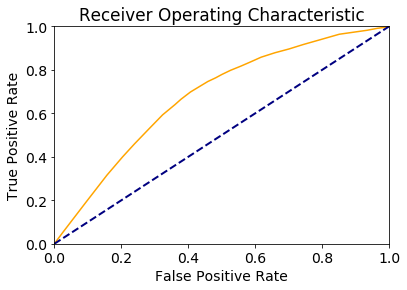

(array([9.99965902e-01, 9.96931156e-01, 9.96760664e-01, 9.96624271e-01,
        9.96590173e-01, 9.96385583e-01, 9.96317387e-01, 9.96317387e-01,
        9.96317387e-01, 9.96180994e-01, 9.96078699e-01, 9.95874109e-01,
        9.95874109e-01, 9.95805913e-01, 9.95703618e-01, 9.95703618e-01,
        9.95703618e-01, 9.95669520e-01, 9.95635421e-01, 9.95601323e-01,
        9.95601323e-01, 9.95567225e-01, 9.95499028e-01, 9.95464930e-01,
        9.95464930e-01, 9.95362635e-01, 9.95362635e-01, 9.95328537e-01,
        9.95328537e-01, 9.95294439e-01, 9.95226242e-01, 9.95192144e-01,
        9.95055751e-01, 9.95055751e-01, 9.94987554e-01, 9.94953456e-01,
        9.94953456e-01, 9.94953456e-01, 9.94919358e-01, 9.94885259e-01,
        9.94885259e-01, 9.94817063e-01, 9.94782965e-01, 9.94782965e-01,
        9.94782965e-01, 9.94748866e-01, 9.94748866e-01, 9.94748866e-01,
        9.94748866e-01, 9.94612473e-01, 9.94578375e-01, 9.94441982e-01,
        9.94441982e-01, 9.94407884e-01, 9.94407884e-01, 9.942714

In [100]:
roc2(gnb_down.predict_proba(Xt_test_down), y_test_down)

In [101]:
TPRs_gnb_down, FPRs_gnb_down = sen_spec(probas=gnb_down.predict_proba(Xt_test_down), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.13390%, Specificity: 3.38315%, Threshold: 71.0%


In [102]:
auc(TPRs_gnb_down, FPRs_gnb_down)


0.6790497299664469

In [103]:
gnb_down_preds = gnb_down.predict(Xt_test_down)

In [116]:
print(classification_report(y_test_down, lr_down_preds))
print(classification_report(y_test_down, rt_lr_pipeline_down_preds))
print(classification_report(y_test_down, rf_down_preds))
print(classification_report(y_test_down, grd_down_preds))
print(classification_report(y_test_down, xgb_down_preds))
print(classification_report(y_test_down, cal_class_lsvc_down_preds))
print(classification_report(y_test_down, gnb_down_preds))


             precision    recall  f1-score   support

          0       0.64      0.64      0.64     29174
          1       0.64      0.64      0.64     29327

avg / total       0.64      0.64      0.64     58501

             precision    recall  f1-score   support

          0       0.65      0.62      0.63     29174
          1       0.64      0.67      0.65     29327

avg / total       0.64      0.64      0.64     58501

             precision    recall  f1-score   support

          0       0.69      0.59      0.63     29174
          1       0.64      0.74      0.69     29327

avg / total       0.66      0.66      0.66     58501

             precision    recall  f1-score   support

          0       0.68      0.59      0.63     29174
          1       0.64      0.73      0.68     29327

avg / total       0.66      0.66      0.66     58501

             precision    recall  f1-score   support

          0       0.68      0.62      0.65     29174
          1       0.66      0.71 

**Class Balance Method 2:** up-sampling the minority class.

In [89]:
df_wburn.ARSON.value_counts()

0    771131
1    146252
Name: ARSON, dtype: int64

In [90]:
df_majority_up = df_wburn[df_wburn.ARSON==0]
df_minority_up = df_wburn[df_wburn.ARSON==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority_up, 
                                 replace=True,     # sample with replacement
                                 n_samples=771131,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_up = pd.concat([df_majority_up, df_minority_upsampled])
 
# Display new class counts
df_up.ARSON.value_counts()

1    771131
0    771131
Name: ARSON, dtype: int64

In [91]:
Xu = df_up.drop(['ARSON'], axis=1)
yu = df_up['ARSON']

In [92]:
X_train_u, X_test_u, yu_train, yu_test = train_test_split(Xu, yu, test_size=0.2, random_state=42)

In [93]:
pca_6_up = PCA(n_components=6)
pca_6_up.fit(X_train_u)
Xu_train = pca_6_up.transform(X_train_u)
Xu_test = pca_6_up.transform(X_test_u)

In [105]:
lr_up = LogisticRegression()
lr_up.fit(Xu_train, yu_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [106]:
rt_up = RandomTreesEmbedding(max_depth=4, n_estimators=n_estimator,
    random_state=42)
rt_lr_up = LogisticRegression()
rt_lr_pipeline_up = make_pipeline(rt_up, rt_lr_up)
rt_lr_pipeline_up.fit(Xu_train, yu_train)

Pipeline(memory=None,
     steps=[('randomtreesembedding', RandomTreesEmbedding(max_depth=4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=42, sp...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [107]:
rf_up = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf_up.fit(Xu_train, yu_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
grd_up = GradientBoostingClassifier(n_estimators=n_estimator)
grd_up.fit(Xu_train, yu_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [109]:
xgb_up = XGBClassifier()
xgb_up.fit(Xu_train, yu_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [110]:
gnb_up = GaussianNB()
gnb_up.fit(Xu_train, yu_train)

GaussianNB(priors=None)

In [111]:
cal_class_lsvc_up = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')
cal_class_lsvc_up.fit(Xu_train, yu_train)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: R

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
            cv=2, method='sigmoid')

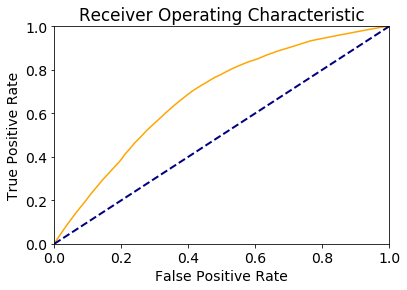

Specificity: 98.53211%, Sensitivity: 3.58512%, Threshold: 73.0%


In [117]:
roc2(lr_up.predict_proba(Xu_test), yu_test)

TPRs_lr_up, FPRs_lr_up = sen_spec(probas=lr_up.predict_proba(Xu_test), true=yu_test, stat="specificity", stat_val = 0.99, step=0.01)

auc(TPRs_lr_up, FPRs_lr_up)

lr_up_preds = lr_up.predict(Xu_test)

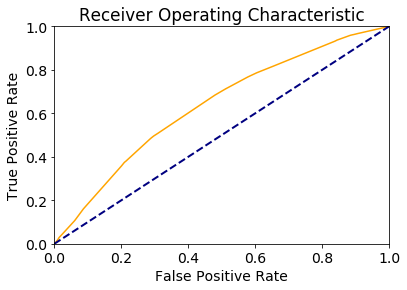

Sensitivity: 99.51518%, Specificity: 1.32741%, Threshold: 27.0%


In [118]:
roc2(rt_lr_pipeline_up.predict_proba(Xu_test), yu_test)

TPRs_pipeline_up, FPRs_pipeline_up = sen_spec(probas=rt_lr_pipeline_up.predict_proba(Xu_test), true=yu_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_pipeline_up, FPRs_pipeline_up)

rt_lr_pipeline_up_preds = rt_lr_pipeline_up.predict(Xu_test)

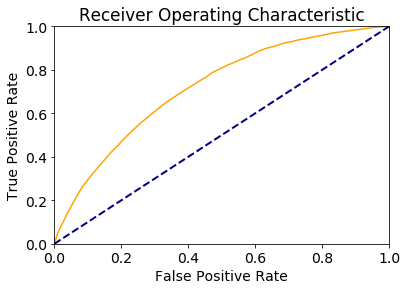

Sensitivity: 99.63735%, Specificity: 3.82419%, Threshold: 20.0%


In [119]:
roc2(rf_up.predict_proba(Xu_test), yu_test)

TPRs_rf_up, FPRs_rf_up = sen_spec(probas=rf_up.predict_proba(Xu_test), true=yu_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_rf_up, FPRs_rf_up)

rf_up_preds = rf_up.predict(Xu_test)

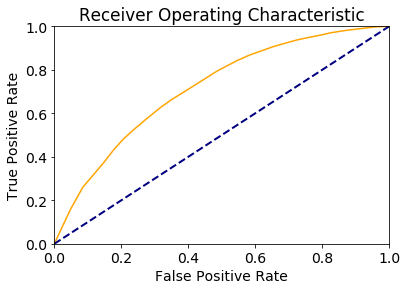

Specificity: 100.00000%, Sensitivity: 0.00000%, Threshold: 64.0%


In [120]:
roc2(grd_up.predict_proba(Xu_test), yu_test)

TPRs_grd_up, FPRs_grd_up = sen_spec(probas=grd_up.predict_proba(Xu_test), true=yu_test, stat="specificity", stat_val = 0.99, step=0.01)

auc(TPRs_grd_up, FPRs_grd_up)

grd_up_preds = grd_up.predict(Xu_test)

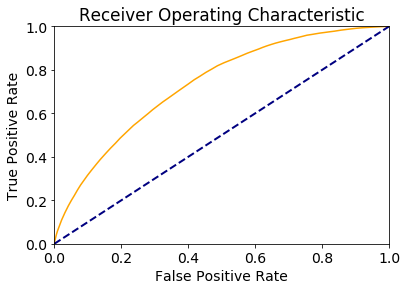

Sensitivity: 99.09305%, Specificity: 9.93769%, Threshold: 16.0%


/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [121]:
roc2(xgb_up.predict_proba(Xu_test), yu_test)

TPRs_xgb_up, FPRs_xgb_up = sen_spec(probas=xgb_up.predict_proba(Xu_test), true=yu_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_xgb_up, FPRs_xgb_up)

xgb_up_preds = xgb_up.predict(Xu_test)

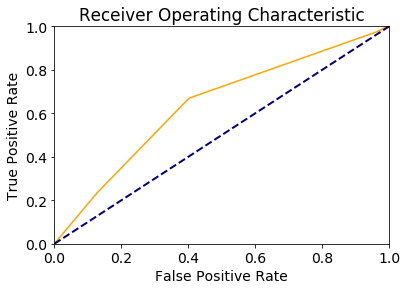

Sensitivity: 99.03294%, Specificity: 1.69162%, Threshold: 47.0%


In [122]:
roc2(cal_class_lsvc_up.predict_proba(Xu_test), yu_test)

TPRs_cal_class_lsvc_up, FPRs_cal_class_lsvc_up = sen_spec(probas=cal_class_lsvc_up.predict_proba(Xu_test), true=yu_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_cal_class_lsvc_up, FPRs_cal_class_lsvc_up)

cal_class_lsvc_up_preds = cal_class_lsvc_up.predict(Xu_test)

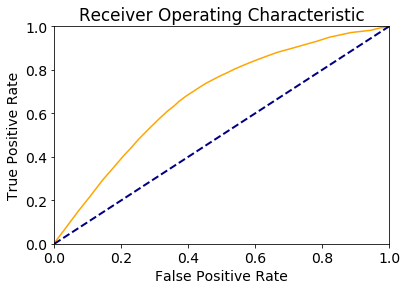

Sensitivity: 99.18485%, Specificity: 2.98911%, Threshold: 59.0%


In [123]:
roc2(gnb_up.predict_proba(Xu_test), yu_test)

TPRs_gnb_up, FPRs_gnb_up = sen_spec(probas=gnb_up.predict_proba(Xu_test), true=yu_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_gnb_up, FPRs_gnb_up)

gnb_up_preds = gnb_up.predict(Xu_test)

In [124]:
print(classification_report(yu_test, lr_up_preds))
print(classification_report(yu_test, rt_lr_pipeline_up_preds))
print(classification_report(yu_test, rf_up_preds))
print(classification_report(yu_test, grd_up_preds))
print(classification_report(yu_test, xgb_up_preds))
print(classification_report(yu_test, cal_class_lsvc_up_preds))
print(classification_report(yu_test, gnb_up_preds))

             precision    recall  f1-score   support

          0       0.64      0.64      0.64    153758
          1       0.64      0.64      0.64    154695

avg / total       0.64      0.64      0.64    308453

             precision    recall  f1-score   support

          0       0.62      0.52      0.57    153758
          1       0.59      0.68      0.63    154695

avg / total       0.60      0.60      0.60    308453

             precision    recall  f1-score   support

          0       0.69      0.58      0.63    153758
          1       0.64      0.74      0.68    154695

avg / total       0.66      0.66      0.66    308453

             precision    recall  f1-score   support

          0       0.68      0.57      0.62    153758
          1       0.63      0.74      0.68    154695

avg / total       0.66      0.66      0.65    308453

             precision    recall  f1-score   support

          0       0.68      0.63      0.65    153758
          1       0.66      0.70 

I got better scores with the downsampled data. This is nice because I'm not creating any new data, robust though that method may be, and it will run faster on the smaller set.

It's time for tuning! I am going to run GridSearchCV() on everything. After that, the final step will be to take the best parameters and then re-train everything on the downsampled data set. After that I can either use the best one as my final model, do some kind of simple ensemble with them if I can figure out a way, or plug them in as inputs to a neural net. I would like to do the last one but I only have 4 days before this is due. We'll see what happens.

The below cells are my ensemble of the above models.

In [132]:
df_downsampled = pd.read_csv('./df_down.csv')

In [133]:
Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xd, yd, test_size=0.8, random_state=42)

X_small_train, X_small_test, y_train, y_test = train_test_split(Xs_train, ys_train, test_size=0.5, random_state=42)


pca_3_down = PCA(n_components=3)
pca_3_down.fit(X_small_train)
X_train = pca_3_down.transform(X_small_train)
X_test = pca_3_down.transform(X_small_test)

In [134]:
n_estimator_ens = 50

In [135]:
lr_ens = LogisticRegression(fit_intercept=False)

rt_ens = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
    random_state=42)
rt_lr_ens = LogisticRegression(fit_intercept=False)
rt_lr_pipeline_ens = make_pipeline(rt_ens, rt_lr_ens)

rf_ens = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)

grd_ens = GradientBoostingClassifier(n_estimators=n_estimator)

xgb_ens = XGBClassifier()

gnb_ens = GaussianNB()

lsvc = LinearSVC(random_state=42)
cal_class_lsvc_ens = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')


In [ ]:
#copied from elsewhere, figured I'd keep them handy in case I wanted to use them.

# rt_lr_pipeline_ens.fit(X_train, y_train)
# rf_ens.fit(X_train, y_train)
# grd.fit(X_train, y_train)
# xgb_ens.fit(Xt_train, y_train)
# gnb_ens.fit(Xt_train, y_train)
# cal_class_lsvc.fit(Xt_train_svc, y_train_svc)


In [136]:
models = [
    ['logistic', lr_ens],  #these are all tuples, "models" is the list of them
    ['rt_lr_pipeline', rt_lr_pipeline_ens],
    ['random forest', rf_ens],
    ['gradient boosting', grd_ens],
    ['XGBoost', xgb_ens],
    ['GaussianNB', gnb_ens],
    ['calibrated LinearSVC', cal_class_lsvc_ens]
]

In [138]:
predictions_train = pd.DataFrame()
for model_tup in models:
    name, model = model_tup
    predictions_train[name + ' _pred'] = cross_val_predict(model, X_train, y_train)
    model.fit(X_train, y_train)
predictions_train.head()

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklear

,logistic _pred,rt_lr_pipeline _pred,random forest _pred,gradient boosting _pred,XGBoost _pred,GaussianNB _pred,calibrated LinearSVC _pred
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0
3,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0


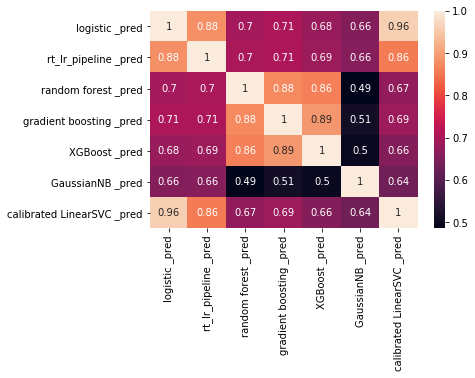

In [139]:
sns.heatmap(predictions_train.corr(), annot=True)

I'm going to use polynomial features for logistic regression, rt_lr_pipeline, rf, and grb.

In [3]:
df_downsampled = pd.read_csv('./df_down.csv')

Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

X_small_train, X_small_test, y_train, y_test = train_test_split(Xd, yd, test_size=0.2, random_state=42)


pca_3_down = PCA(n_components=3)
pca_3_down.fit(X_small_train)
X_train = pca_3_down.transform(X_small_train)
X_test = pca_3_down.transform(X_small_test)


In [9]:
n_estimator_ens = 75

In [4]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [19]:
lr = LogisticRegression(fit_intercept=False)
lr_pipe = Pipeline([
    ('poly', poly),
    ('logistic regression', lr)
])

In [13]:
# rt_ens = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator_ens,
#     random_state=42)
# rt_lr_ens = LogisticRegression(fit_intercept=False)

# rt_lr_pipeline2_ens = make_pipeline([
#     ('poly', poly),
#     ('rt_ens', rt_ens),
#     ('rt_lr_ensemble', rt_lr_ens),
#     ])


TypeError: Last step of Pipeline should implement fit. '[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('rt_ens', RandomTreesEmbedding(max_depth=3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           random_state=42, sparse_output=True, verbose=0,
           warm_start=False)), ('rt_lr_ensemble', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]' (type <class 'list'>) doesn't

In [20]:

rf_ens = RandomForestClassifier(max_depth=3, n_estimators=n_estimator_ens)
rf_pipe_ens = Pipeline([
    ('poly', poly),
    ('random forest', rf_ens)
])


In [21]:

grd_ens = GradientBoostingClassifier(n_estimators=n_estimator_ens)
grd_pipe_ens = Pipeline([
    ('poly', poly),
    ('gradient boosted', grd_ens)
])

In [18]:
xgb_ens = XGBClassifier()

gnb_ens = GaussianNB()

lsvc = LinearSVC(random_state=42)
cal_class_lsvc_ens = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')

In [22]:
models_poly = [
    ['logistic_poly', lr_pipe], 
    ['random forest', rf_pipe_ens],
    ['gradient boosting', grd_pipe_ens],
    ['XGBoost', xgb_ens],
    ['GaussianNB', gnb_ens],
    ['calibrated LinearSVC', cal_class_lsvc_ens]
]

In [24]:
predictions_train_poly = pd.DataFrame()
for model_tup in models_poly:
    name, model = model_tup
    predictions_train_poly[name + ' _pred'] = cross_val_predict(model, X_train, y_train)
    model.fit(X_train, y_train)
predictions_train_poly.head()

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklear

,logistic_poly _pred,random forest _pred,gradient boosting _pred,XGBoost _pred,GaussianNB _pred,calibrated LinearSVC _pred
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,1,1,0,1,0
3,1,0,0,0,0,0
4,1,1,1,1,1,0


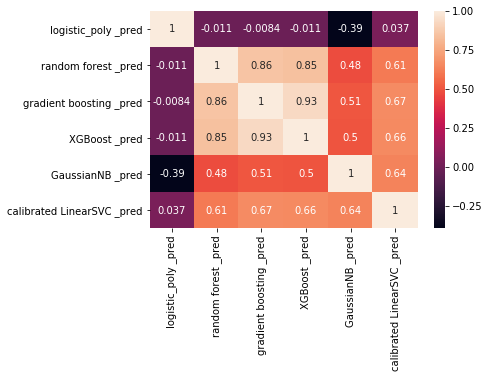

In [25]:
sns.heatmap(predictions_train_poly.corr(), annot=True)

In [34]:
ada_agg = AdaBoostClassifier(n_estimators=100)

In [35]:
ada_agg.fit(predictions_train_poly, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [36]:
predictions_test = pd.DataFrame()
for model_tup in models_poly:
    name, model = model_tup
    predictions_test[name + ' _pred'] = model.predict(X_test)
predictions_test.head(4)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:510: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(self.a_ * T + self.b_))


,logistic_poly _pred,random forest _pred,gradient boosting _pred,XGBoost _pred,GaussianNB _pred,calibrated LinearSVC _pred
0,1,0,0,0,0,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,0,0,0,0,0


In [44]:
predictions_test.shape

(29250, 6)

In [37]:
ada_agg.score(predictions_test, y_test)

0.6663589743589744

In [39]:
ada_agg_preds = ada_agg.predict(predictions_test)

In [41]:
print(classification_report(y_test, ada_agg_preds))

             precision    recall  f1-score   support

          0       0.66      0.67      0.67     14667
          1       0.67      0.66      0.66     14583

avg / total       0.67      0.67      0.67     29250



**The below cells are code for running on AWS.**

In [ ]:
df_downsampled = pd.read_csv('./df_down.csv')

In [ ]:
Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

Xd_train, Xd_test, y_train, y_test = train_test_split(Xd, yd, test_size=0.2, random_state=42)

pca_6_down = PCA(n_components=6)
pca_6_down.fit(Xd_train)
X_train = pca_6_down.transform(Xd_train)
X_test = pca_6_down.transform(Xd_test)

In [ ]:
gs_log_params = {
    'penalty':['l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_log_params, cv=5, verbose=1)

lr_gridsearch = lr_gridsearch.fit(X_train, y_train)

In [ ]:
print('logreg best training score: ' + lr_gridsearch.best_score_)
print('logreg best params: ' + lr_gridsearch.best_params_)

In [ ]:
best_lr = lr_gridsearch.best_estimator_
print('best log best test score: ' + best_lr.score(X_test, y_test))